# Aggregating Data with CAQL

In [1]:
%run preamble.py
%matplotlib inline

## Aggregating data over time

### The rolling:* package

Function in the rolling:* package allow you to calculate rolling aggregates over time.

Docs: https://login.circonus.com/resources/docs/user/caql_reference.html#Packagerolling

* rolling:mean(window_duration) - The arithmetic mean of the values over the specified time window.
* rolling:sum(window_duration) - The sum of the values over the specified time window.
* rolling:max(window_duration) - The maximum of the values over the specified time window.

There is also:

* histogram:rolling(window_duration) - Aggregate histograms over the specified window duration.

**HINT:** The window_duration should be specified as a duration literal e.g. `5M`, `1d`, `3w`

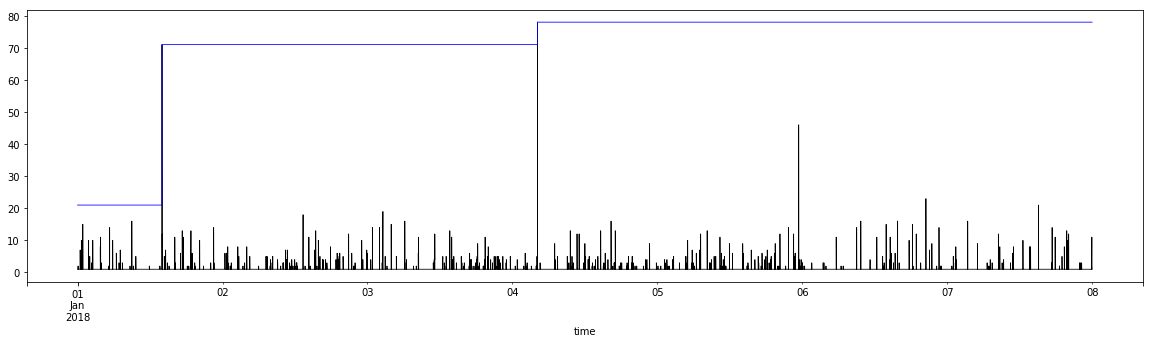

In [27]:
ax = caql_plot("demo", '''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration")

''', datetime(2018,1,1), 60, 60*24*7, color="black");
caql_plot("demo", '''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration")
| rolling:max(7d)

''', datetime(2018,1,1), 60, 60*24*7, color="blue", ax=ax)

## The window:* package

The window package allows you to calculate aggregates over time windows.

E.g.

* window:mean(window_duration)
* window:sum(window_duration)
* window:max(window_duration)

**CAVEAT:** Since we follow a stream processing model, we need to wait until a window is completely over, before we can calculate statistics over the window.

![](img/window_pu.png)

This is different from other tools, which display window statistics over the time frame of the window.

**TODO:** Deprecate `window:*` in favor of `batch:window:*` which does not have this caveat but it not supported in CAQL checks.

**HINT:** The original data can be delayed using `delay()` to bring it into alignment with the window.

**CAVEAT:** The alignment of the windows will depend on the start_time of the dispay. There is no way to influence window alignment.

**TODO:** Allow the user to explicily specify the window alignment. There are already time-zone aware functions in CAQL, e.g. `time:tz("UTC", "minutes")` will work.

~~**TODO:** Document the time:* package.~~

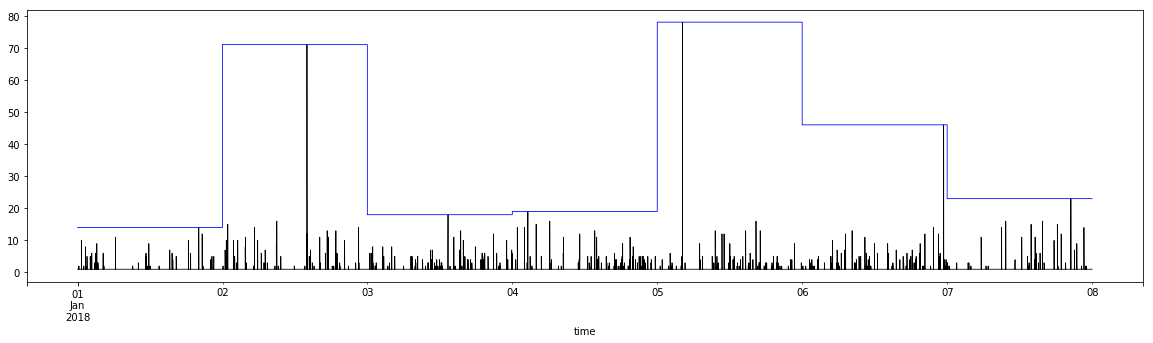

In [29]:
from matplotlib import pyplot as plt

ax1 = caql_plot("demo", '''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") 
| delay(1d)

''', datetime(2018,1,1), 60, 60*24*7, color="black");
caql_plot("demo", '''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") 
| window:max(1d)

''', datetime(2018,1,1), 60, 60*24*7, ax=ax1, color="blue");

# VIEW_RANGE and VIEW_PERIOD

CAQL defines two constants that are occasinally useful for aggregation:

* VIEW_RANGE the duration of the currently active view range of a graph. E.g. if you are looking at two weeks of data, VIEW_RANGE will have a numeric value equal to the 2w duration literal. When used in CAQL checks, the value will be equal to 1M.
* VIEW_PERIOD the "period duration" of the current active view of a graph. This is the minimal duration that is visually represented in a graph. E.g. if you are looking at one year of data, VIEW_PERIOD will be equal to 12h. When used in CAQL checks, the value will be equal to 1M.

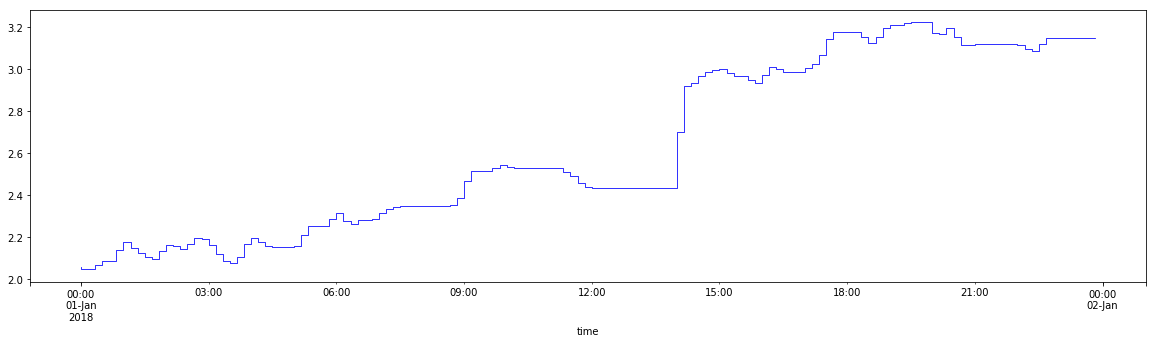

In [19]:
caql_plot("demo", '''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration") 
| window:max(VIEW_PERIOD)
| rolling:mean(VIEW_RANGE)

''', datetime(2018,1,1), 600, 6*24, color="blue");

## Aggregating data across metrics


The stat:* package provides a number of data aggregation primitives, that can be used across metrics.

* stats:sum() - Returns sum of all input slots. Missing values are treated like 0.
* stats:max([B]) - Return the maximum of all input values.
  B - (optional) optional number, that is included in max calculation. Use for e.g. stats:max(0)

**TODO:** Add stats:top(N) function.

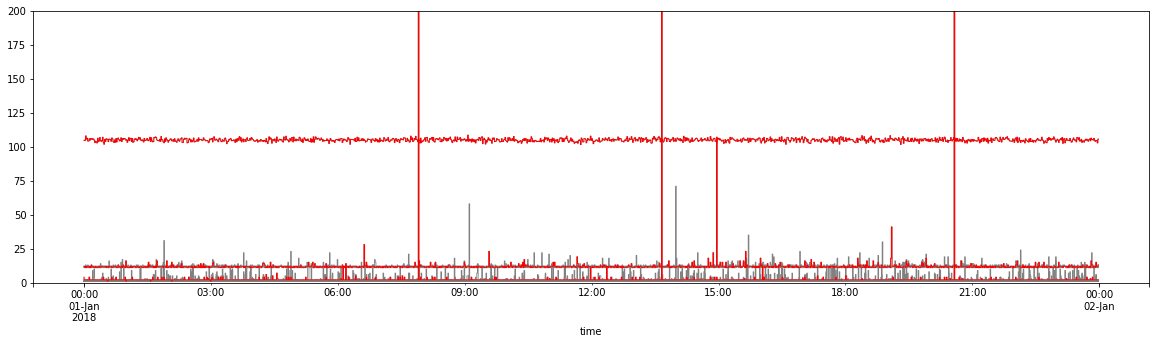

In [34]:
ax1 = caql_plot("demo", '''search:metric("duration")''', datetime(2018,1,1), 60, 60*24, color="grey");
caql_plot("demo", '''

search:metric("duration") | top(3, method="max")

''', datetime(2018,1,1), 60, 60*24, ax=ax1, color="red").set_ylim(0,200);

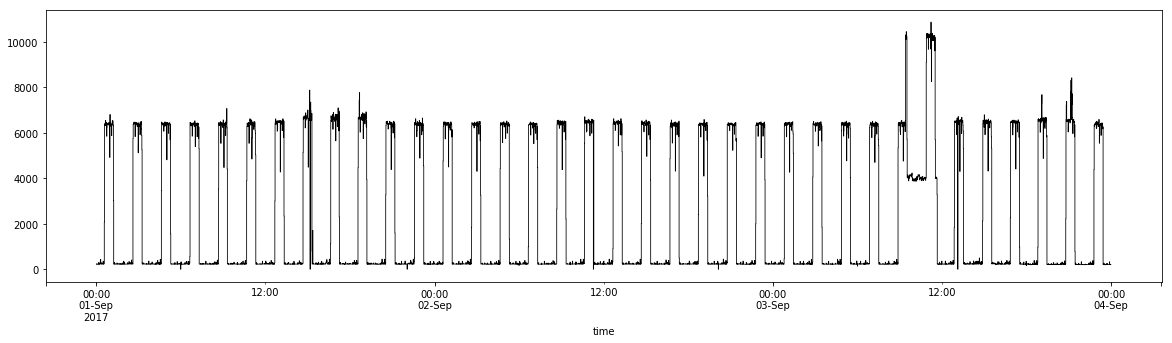

In [35]:
caql_plot("excite", '''

search:metric:counter("(metric_name:bpf`syscall`count*)") 
| stats:sum()

''', datetime(2017,9,1), 60, 60*24*3, color="black");

## Aggregating data as Histograms

The `histogram()` CAQL function can be used to create a histogram stream from multiple numeric input streams.

Example: https://demo.circonus.com/trending/graphs/edit/353a1ddc-7926-44ca-b92e-ed93f5c9eb1a

This allows the application of all histogram transformations to streams of numeric data.
We will hear more about histograms later, for the moment we will only show one example.

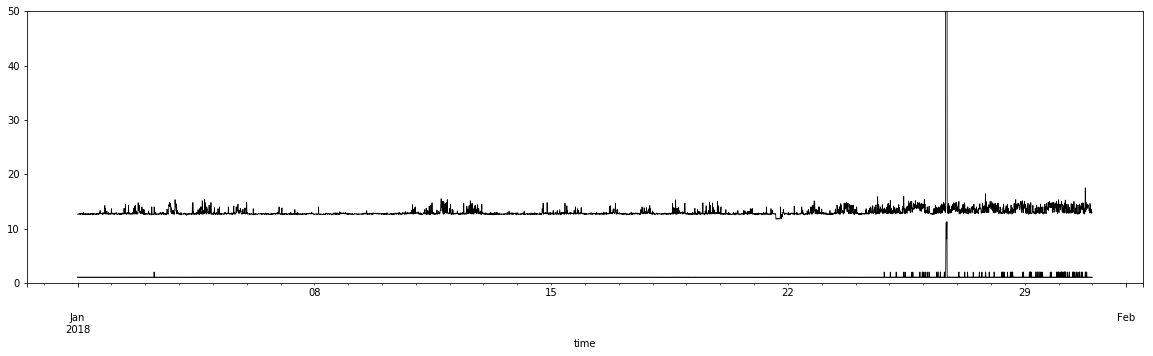

In [110]:
caql_plot("demo", '''

search:metric("duration") | histogram() | histogram:percentile(10,50,90)

''', datetime(2018,1,1), 600, 60*24*3, color="black").set_ylim(0,50);

## Application: Contextualizing Data

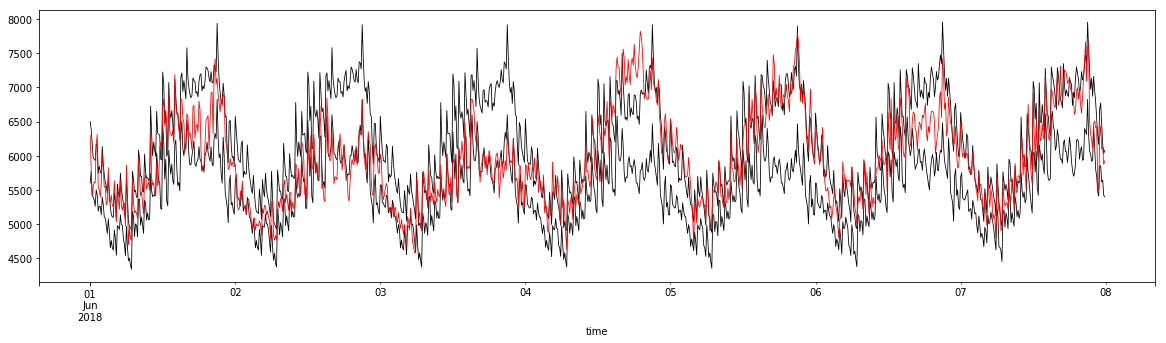

In [21]:
ax1 = caql_plot("ops", '''

metric:counter("af84f742-fa85-41bf-85b2-ea3c780ae6d5","exchanges`_aggregate`routed")
| delay(1d, 2d, 3d, 4d, 5d, 6d, 7d, 8d, 9d, 10d)
| histogram()
| histogram:percentile(20,80)

''', datetime(2018,6,1), 600, 6*24*7, color="black");

caql_plot("ops", '''

metric:counter("af84f742-fa85-41bf-85b2-ea3c780ae6d5","exchanges`_aggregate`routed")

''', datetime(2018,6,1), 600, 6*24*7, color="red", ax=ax1);

## Application Outlier Detection

Blog: https://www.circonus.com/casestudies/touchtunes/

Example Graph (computed): https://circonus-ops.circonus.com/trending/graphs/edit/519d6628-1cd8-453c-b7a5-a230737b458a

Example Graph (materialized): https://circonus-ops.circonus.com/trending/graphs/view/1e08ac40-3a1b-4075-b7ab-9c20dd20a94e